Outline:

1. Data processing and parsing
1. How to create a VIT from the GPT code
    1. Change to an encoder
    1. Handling the position embedding
    1. Binning the continuous values
1. Making A Multi-Modal Model for the Generalist Robotics Policy
    1. Adding the text goals
    1. Sanitising the data and standardization.
    1. Adding goal images
    1. Adding the input masking
1. Evaluating the model in sim
1. Recording videos of the results for evaluation

## Get full trajectories
Instead of a single image we want something that looks more like a sequence, similar to text. 
For robotics applications our "language" is images and actions.

### Load Datasets

The data for robotics applications is often more complicated. There are images, actions and text descriptions. Also, the text descriptions is per episode, instead of at each frame, which is common for RL/BC.

In [ ]:
!git clone https://github.com/milarobotlearningcourse/mini-grp.git
%cd mini-grp
!pip3 install -r requirements.txt

# Install repo
import cv2
import tensorflow_datasets as tfds
import tqdm
import rlds, numpy as np
import mediapy as media
from PIL import Image
from IPython import display

/home/gberseth/miniconda3/envs/roble/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-19 11:11:00.914805: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-19 11:11:01.167923: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 11:11:01.168003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 11:

2024-09-18 14:25:52.052295: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".
2024-09-18 14:25:56.169663: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-18 14:25:56.256029: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned abov

{'steps': <_VariantDataset element_spec={'action': {'open_gripper': TensorSpec(shape=(), dtype=tf.bool, name=None), 'rotation_delta': TensorSpec(shape=(3,), dtype=tf.float32, name=None), 'terminate_episode': TensorSpec(shape=(), dtype=tf.float32, name=None), 'world_vector': TensorSpec(shape=(3,), dtype=tf.float32, name=None)}, 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'observation': {'image': TensorSpec(shape=(480, 640, 3), dtype=tf.uint8, name=None), 'natural_language_embedding': TensorSpec(shape=(512,), dtype=tf.float32, name=None), 'natural_language_instruction': TensorSpec(shape=(), dtype=tf.string, name=None), 'state': TensorSpec(shape=(7,), dtype=tf.float32, name=None)}, 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None)}>}
Instruction: Place the can to the left of the pot.


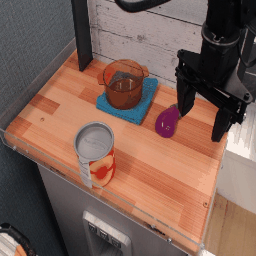

In [2]:
from PIL import Image
from IPython import display
def as_gif(images, path='temp.gif'):
  # Render the images as the gif:
  images = [Image.fromarray(image) for image in images]
  images[0].save(path, save_all=True, append_images=images[1:], duration=1000, loop=0)
  gif_bytes = open(path,'rb').read()
  return gif_bytes

# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
dataset = builder.as_dataset(split='train[:1]')

# sample episode + resize to 256x256 (default third-person cam resolution)
episode = next(iter(dataset))
print(episode)

steps = list(episode['steps'])
images = np.array([cv2.resize(np.array(step['observation']['image']), (256, 256)) for step in steps])

# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[0]['observation']['natural_language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
display.Image(as_gif(images))

In [ ]:
## Looking at the actions
import matplotlib.pyplot as plt

actions = np.array([np.array(step['action']['world_vector']) for step in steps])

plt.plot(actions[:, 0], label='x')
plt.plot(actions[:, 1], label='y')
plt.plot(actions[:, 2], label='z')
plt.legend()
plt.show()

In [6]:
## Grab a chunk of data for training
image_shape = [64, 64, 3]
num_episodes = 20 ## How many episodes to grab from the dataset for training

builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
datasetRemote = builder.as_dataset(split='train[:' + str(num_episodes) + ']')
dataset = {"img": [], "action": [], "goal": [], "goal_img": [],
                "rotation_delta": [], "open_gripper": [] }
shortest_goal_txt = 10000000000
for episode in datasetRemote:
    episode_ = {'steps': [] }
    episode = list(episode['steps'])
    ## Goal image is just the last image/state/observation in the episode
    goal_img = cv2.resize(np.array(episode[-1]['observation']['image'], dtype=np.float32), (image_shape[0], image_shape[1]))  
    for i in range(len(episode)):
        obs = cv2.resize(np.array(episode[i]['observation']['image'], dtype=np.float32), (image_shape[0], image_shape[1])) 
        goal = episode[i]['observation']['natural_language_instruction'].numpy().decode()
        dataset["img"].append(obs)
        dataset["action"].append(np.array(episode[i]['action']['world_vector']))
        dataset["rotation_delta"].append(np.array(episode[i]['action']['rotation_delta']))
        dataset["open_gripper"].append(np.array(episode[i]['action']['open_gripper']))
        dataset["goal"].append(goal)
        dataset["goal_img"].append(goal_img)
        if len(goal) < shortest_goal_txt: shortest_goal_txt = len(goal)

# here are all the unique characters that occur in this text
chars = sorted(list(set([item for row in dataset["goal"] for item in row])))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode_txt = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode_txy = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
print("vocab_size:", vocab_size)
print("example text encode:", encode_txt(dataset["goal"][0]))

print("Dataset shape:", len(dataset["img"]))
dataset["img"] = np.array(dataset["img"], dtype=np.uint8)
dataset["action"] = np.array(dataset["action"], dtype=np.float32)
# dataset["goal"] = np.array(encode_txt(dataset["goal"]), dtype=np.float32)
dataset["goal_img"] = np.array(dataset["goal_img"], dtype=np.uint8)


2024-09-19 11:12:00.314737: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-09-19 11:12:00.314764: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: voyager
2024-09-19 11:12:00.314769: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: voyager
2024-09-19 11:12:00.314827: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.183.1
2024-09-19 11:12:00.314842: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.183.1
2024-09-19 11:12:00.314846: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.183.1


vocab_size: 29
example text encode: [4, 16, 6, 8, 10, 0, 23, 13, 10, 0, 8, 6, 18, 0, 23, 19, 0, 23, 13, 10, 0, 16, 10, 11, 23, 0, 19, 11, 0, 23, 13, 10, 0, 20, 19, 23, 2]
Dataset shape: 172


# How to create a VIT from the Transformer (NanoGPT) code
We have some familiarity with a robotics dataset. It contains multiple types of inputs, text and images and outputs, continuous values We need to make a model that will process in the input data and output the correct values depending on the input observation (img) and goal (text or image). I am going to extend some of Karpathi's gpt-nano code to keep as much of the model and details visable as we learn about this process. We will start with creating a vision transformer from the code.

In [4]:
## Need to adjust the masking. 
# We can have fully connected attention (encoder) or partially attended transformers. 
# Need to discuss this because we are going to modify this a couple times for our GRP.
# For images we want an encoder
import torch
import torch.nn as nn
from torch.nn import functional as F
# Self-attention
torch.manual_seed(1338)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# One head self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False) ## Here is what I am interested in
query = nn.Linear(C, head_size, bias=False) ## This is what I have
value = nn.Linear(C, head_size, bias=False) ## Here is what I will communicate if you find me useful
k = key(x)   # (B, T, 32)
q = query(x) # (B, T, 32)
wei =  q @ k.transpose(-2, -1) # (B, T, 32) @ (B, 32, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
# wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) ## Remove this to make an encoder
wei = F.softmax(wei, dim=-1) ## This normalizes the values for a good distribution (sum to 1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

In [ ]:
## Look at the attension for one head
wei[0]

## Vision transformer Code

In [7]:
import torch
import torch.nn as nn
from torch.nn import functional as F

## This is an encoder head with full attention 
class Head(nn.Module):
    
    def __init__(self, head_size, n_embd, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        # wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T) ## Remove masking
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ Create multiple heads for self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd=n_embd, dropout=dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication then computation """

    def __init__(self, n_embd, n_head, dropout):
        ## n_embd: embedding dimension, n_head: the number of heads we want
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd=n_embd, dropout=dropout)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


## Tokenizing Images
Transformers process tokens. The nano GPT model was designed to treat each letter as an individual token and train a model to continue outputing more tokens given a recent context of tokens. However most LLMs break up words into phonemes and pieces of words in a particular way to both represent the possible components of words well and keep the number of possible tokens within a reasonable number. This asks the question, how to tokenize an image? We litterally chop the image into $m$ equally sized __patches__.

In [13]:
def get_patches_fast(images):
    from einops import rearrange
    n_patches = 8
    batch_size, channels, height, width = images.shape
    patch_size = height // n_patches
    patches = rearrange(images, 'b (h p1) (w p2) c -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size)
    return patches

In [ ]:
out = get_patches_fast(torch.tensor(dataset["img"][:5]))
out[0]

### Compute the Position Embeddings

These embeddings help the transformer keep track of where items are located in the image.

In [ ]:
def calc_positional_embeddings(sequence_length, d):
    out = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            out[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return out

Show some of the patching with images.

In [9]:
## Helper routines to simple training.

# data loading
def get_batch_vit(split, dataset, batch_size):
    # generate a small batch of inputs x and targets y
    data = dataset['train'] if split == 'train' else dataset['test']
    ix = np.random.randint(int(len(data["img"])), size=(batch_size,))
    x = torch.tensor(data["img"][ix], dtype=torch.float)
    y = torch.tensor(data["label"][ix], dtype=torch.long)
    return x, y

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(model._cfg.eval_iters)
        for k in range(model._cfg.eval_iters):
            X, Y = get_batch_vit(split, model._dataset, model._cfg.batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [10]:
from hydra import compose, initialize
initialize(config_path="./conf", job_name="test_app")

hydra.initialize()

In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

import tensorflow_datasets as tfds
import numpy as np
from tqdm import tqdm, trange
import cv2


class VIT(nn.Module):
  def __init__(self, dataset, cfg, mlp_ratio=4):
    super(VIT, self).__init__()
    self._dataset = dataset
    self._cfg = cfg
    self.patch_size = (cfg.image_shape[0] / cfg.n_patches, cfg.image_shape[1] / cfg.n_patches)

    #Positional embedding
    self.register_buffer('positional_embeddings', calc_positional_embeddings(cfg.n_patches ** 2 + 1, cfg.n_embd), persistent=False)
    
    self.class_tokens = nn.Parameter(torch.rand(1, cfg.n_embd))

    self.input_d = int(cfg.image_shape[2] * self.patch_size[0] * self.patch_size[1])

    self.lin_map = nn.Linear(self.input_d, cfg.n_embd, bias=False) 

    # 4) Transformer encoder blocks
    self.blocks = nn.ModuleList([Block(cfg.n_embd, cfg.n_head, dropout=self._cfg.dropout) for _ in range(cfg.n_blocks)])

    # 5) Classification MLP
    self.mlp = nn.Sequential(
        nn.Linear(cfg.n_embd, cfg.action_bins),
        nn.Softmax(dim=-1)
    )

  def forward(self, images, targets=None):
    # Dividing images into patches
    n, c, h, w = images.shape
    patches = get_patches_fast(images)
    
    # Running linear layer tokenization
    # Map the vector corresponding to each patch to the hidden size dimension
    out = self.lin_map(patches)
    
    # Adding classification token to the tokens
    out = torch.cat((self.class_tokens.expand(n, 1, -1), out), dim=1)
    
    # Adding positional embedding
    out = out + self.positional_embeddings.repeat(n, 1, 1)
    
    # Transformer Blocks
    for block in self.blocks:
        out = block(out)

    # Getting the classification token only
    out = out[:, 0]
    logits = self.mlp(out)
        
    if targets is None:
        loss = None
    else:
        # B,T,C = 4,8,2 # batch, time, channels
        B, C = logits.shape
        targets = targets.view(B)
        loss = F.cross_entropy(logits, targets)
    return (logits, loss)


In [ ]:

def my_main():
    
    from hydra import compose, initialize
    from omegaconf import DictConfig, OmegaConf
    cfg = compose(config_name="vit-64", overrides=["+env=absolute_path"])

    torch.manual_seed(cfg.r_seed)
    print ("cfg:", OmegaConf.to_yaml(cfg))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    from datasets import load_dataset
    ds = load_dataset(cfg.dataset)

    print('Features:', ds["train"].features)
    trim = 1000 ## Lets see how little data is needed to still get good performance. 1000 is not enough, any more than that and Google Colab runs out of memory...
    dataset = {}
    dataset["train"]= {
            "img": torch.tensor(np.array(ds["train"]["img"][:trim], dtype=np.uint8)).to(device),
            "label": torch.tensor(np.array(ds["train"]["label"][:trim], dtype=np.uint8)).to(device) 
            }         
    dataset["test"]=  {
            "img": torch.tensor(np.array(ds["test"]["img"][:trim], dtype=np.uint8)).to(device),
            "label": torch.tensor(np.array(ds["test"]["label"][:trim], dtype=np.uint8)).to(device)
            }
    model = VIT(dataset, cfg)
    m = model.to(device)
    # print the number of parameters in the model
    print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.learning_rate)

    for iter in range(cfg.max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % cfg.eval_interval == 0 or iter == cfg.max_iters - 1:
            losses = estimate_loss(model)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # sample a batch of data
        xb, yb = get_batch_vit('train', dataset, cfg.batch_size)

        # evaluate the loss
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    return losses['val']

if __name__ == "__main__":
    import os
    results = my_main()
    print("results:", results)

# Generalist Robotics Policies (GRPs)
These models need multiple types of inputs.
(goal_text, goal_image, observation_img, robot_post, robot_velocity) -> GRP -> action
Let's start with adding text conditioning

## Adding text goals

In [18]:
class GRP(nn.Module):
  def __init__(self, dataset, cfg, mlp_ratio=4):
    super(GRP, self).__init__()
    self._dataset = dataset
    self._cfg = cfg

    self.token_embedding_table = nn.Embedding(cfg.vocab_size, cfg.n_embd)
    self.patch_size = (self._cfg.image_shape[0] / self._cfg.n_patches, self._cfg.image_shape[1] / self._cfg.n_patches)

    #Positional embedding
    self.register_buffer('positional_embeddings', calc_positional_embeddings(1 + self._cfg.n_patches ** 2 + self._cfg.block_size, cfg.n_embd), persistent=False)
    
    self.class_tokens = nn.Parameter(torch.rand(1, cfg.n_embd))

    self.input_d = int(self._cfg.image_shape[2] * self.patch_size[0] * self.patch_size[1])

    self.lin_map = nn.Linear(self.input_d, self._cfg.n_embd, bias=False) 

    # 4) Transformer encoder blocks
    self.blocks = nn.ModuleList([Block(self._cfg.n_embd, self._cfg.n_head, dropout=self._cfg.dropout) for _ in range(self._cfg.n_blocks)])

    # 5) Classification MLPk
    self.mlp = nn.Sequential(
        nn.Linear(self._cfg.n_embd, self._cfg.action_bins),
        nn.Softmax(dim=-1)
    )

  def _init_weights(self, module):
      if isinstance(module, nn.Linear):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
          if module.bias is not None:
              torch.nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Embedding):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, images, goals, targets=None):
    # Dividing images into patches
    n, c, h, w = images.shape
    patches = get_patches_fast(images)
    goals_e = self.token_embedding_table(goals)
    
    out = self.lin_map(patches)
    
    # Adding classification and goal_img tokens to the tokens
    out = torch.cat((self.class_tokens.expand(n, 1, -1), out, goals_e), dim=1)
    
    # Adding positional embedding
    out = out + self.positional_embeddings.repeat(n, 1, 1)
    
    # Transformer Blocks
    for block in self.blocks:
        out = block(out)

    # Getting the classification token only
    out = out[:, 0]
    logits = self.mlp(out)
        
    if targets is None:
        loss = None
    else:
        B, C = logits.shape
        targets = targets.view(B)
        loss = F.cross_entropy(logits, targets)
    return (logits, loss)

In [12]:
## Helper routines to simpel training.

# data loading
def get_batch_vit(split, dataset, batch_size):
    # generate a small batch of inputs x and targets y
    data = dataset['train'] if split == 'train' else dataset['test']
    ix = np.random.randint(int(len(data["img"])), size=(batch_size,))
    x = torch.tensor(data["img"][ix], dtype=torch.float)
    x_g = torch.tensor(data["goal"][ix], dtype=torch.long)
    y = torch.tensor(data["action"][ix], dtype=torch.long)
    return x, x_g, y

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(model._cfg.eval_iters)
        for k in range(model._cfg.eval_iters):
            X, G, Y = get_batch_vit(split, model._dataset, model._cfg.batch_size)
            logits, loss = model(X, G, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


In [ ]:
## Binning the action space.
import matplotlib.pyplot as plt

hist, bin_edges = np.histogram(dataset['action'][:,0], density=True, bins=10)
print("action histogram:", hist)
# print("bin edges: ", bin_edges)
plt.plot(hist)

#plot barplot of histograms
plt.hist(dataset['action'][:,0], bins=10)

In [ ]:

import torch
import torch.nn as nn
from torch.nn import functional as F
from omegaconf import DictConfig, OmegaConf

def my_main():
    from hydra import compose, initialize
    cfg = compose(config_name="bridge-64", overrides=["+env=absolute_path"])
    print ("cfg:", OmegaConf.to_yaml(cfg))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    cfg.block_size = shortest_goal_txt = min([len(txt) for txt in dataset["goal"]])

    # here are all the unique characters that occur in this text
    chars = sorted(list(set([item for row in dataset["goal"] for item in row]))) ## Flatten to a long string
    cfg.vocab_size = len(chars)
    # create a mapping from characters to integers
    stoi = { ch:i for i,ch in enumerate(chars) }
    itos = { i:ch for i,ch in enumerate(chars) }
    encode_txt = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
    decode_txy = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
    print("vocab_size:", cfg.vocab_size)
    print("example text encode:", encode_txt(dataset["goal"][0]))

    import pandas as pd
    action_labels = pd.qcut(np.reshape(dataset["action"][:,:1], (dataset["action"].shape[0])), cfg.action_bins, labels=False)
    hist, bin_edges = np.histogram(action_labels, density=True, bins=cfg.action_bins)
    print("action histogram:", hist)

    ## Get the states and encode them to map to [-1, 1]
    encode_state = lambda af:   ((af/(255.0)*2.0)-1.0).astype(np.float32) # encoder: take a float, output an integer
    resize_state = lambda sf:   cv2.resize(np.array(sf, dtype=np.float32), (cfg.image_shape[0], cfg.image_shape[1]))  # resize state

    dataset_tmp = {
        "img": torch.tensor(encode_state(dataset["img"])).to(device),
        "action": torch.tensor(np.reshape(action_labels, (dataset["action"].shape[0], 1)), dtype=torch.uint8).to(device),            
        "goal_img": torch.tensor(encode_state(dataset["goal_img"])).to(device),
        "goal": torch.tensor([encode_txt(goal[:shortest_goal_txt]) for goal in dataset["goal"]]).to(device)
    }

    print("Dataset shape:", len(dataset_tmp["img"]))
    dataset_tmp = {"train": dataset_tmp, "test": dataset_tmp} 

    model = GRP(dataset_tmp, cfg)
    model = model.to(device)
    # print the number of parameters in the model
    print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.learning_rate)

    for iter in range(cfg.max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % cfg.eval_interval == 0 or iter == cfg.max_iters - 1:
            losses = estimate_loss(model)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # sample a batch of data
        xb, xg, yb = get_batch_vit('train', dataset_tmp, cfg.batch_size)

        # evaluate the loss
        logits, loss = model(xb, xg, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

if __name__ == "__main__":
    import os
    results = my_main()
    print("results:", results)

In [ ]:
## Need to convert the continuous actions into discrete bins    
import matplotlib.pyplot as plt

hist, bin_edges = np.histogram(dataset['action'][:,0], density=True, bins=10)
print("action histogram:", hist)
# print("bin edges: ", bin_edges)
# plt.plot(hist)

#plot barplot of histograms
plt.hist(dataset['action'][:,0], bins=10)

## Making a useful model

Most of the prior steps have shown how to process the data and get training to run, but not to work.
Now we want a model we can use, and what has been missing is providing an output for all dimensions of the action space.

In [ ]:
class GRP(nn.Module):
  def __init__(self, dataset, cfg, mlp_ratio=4):
    super(GRP, self).__init__()
    self._dataset = dataset
    self._cfg = cfg

    self.token_embedding_table = nn.Embedding(cfg.vocab_size, cfg.n_embd)
    self.patch_size = (self._cfg.image_shape[0] / self._cfg.n_patches, self._cfg.image_shape[1] / self._cfg.n_patches)

    #Positional embedding
    self.register_buffer('positional_embeddings', calc_positional_embeddings(1 + self._cfg.n_patches ** 2 + self._cfg.block_size, cfg.n_embd), persistent=False)
    
    self.class_tokens = nn.Parameter(torch.rand(1, cfg.n_embd))

    self.input_d = int(self._cfg.image_shape[2] * self.patch_size[0] * self.patch_size[1])

    self.lin_map = nn.Linear(self.input_d, self._cfg.n_embd, bias=False) 

    # 4) Transformer encoder blocks
    self.blocks = nn.ModuleList([Block(self._cfg.n_embd, self._cfg.n_head, dropout=self._cfg.dropout) for _ in range(self._cfg.n_blocks)])

    # 5) Classification MLP
    self.mlp = nn.Sequential(
       ## Simple have the model produce more outputs B x C x A
        nn.Linear(cfg.n_embd, cfg.action_bins * cfg.action_dim),
        nn.LayerNorm(cfg.action_bins * cfg.action_dim), # Need layer norm to get this to optimize better
        # nn.Dropout(self._cfg.dropout),
        nn.Softmax(dim=-1)
    )

  def _init_weights(self, module):
      if isinstance(module, nn.Linear):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
          if module.bias is not None:
              torch.nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Embedding):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, images, goals, targets=None):
    # Dividing images into patches
    n, c, h, w = images.shape
    patches = get_patches_fast(images)
    goals_e = self.token_embedding_table(goals)

    # Map the vector corresponding to each patch to the hidden size dimension
    out = self.lin_map(patches)
    
    # Adding classification and goal_img tokens to the tokens
    out = torch.cat((self.class_tokens.expand(n, 1, -1), out, goals_e), dim=1)
    
    # Adding positional embedding
    out = out + self.positional_embeddings.repeat(n, 1, 1)
    
    # Transformer Blocks
    for block in self.blocks:
        out = block(out)

    # Getting the classification token only
    out = out[:, 0]
    logits = self.mlp(out)
        
    if targets is None:
        loss = None
    else:
        B, C = targets.shape
        logits = logits.view(B, self._cfg.action_bins, C)
        loss = F.cross_entropy(logits, targets) ## Supports multi dimensions multi-class classification.
    return (logits, loss)

In [ ]:
import hydra, json
from omegaconf import DictConfig, OmegaConf


def my_main():
    from hydra import compose, initialize
    # initialize(config_path="./conf", job_name="test_app")
    cfg = compose(config_name="bridge-64", overrides=["+env=absolute_path"])
    torch.manual_seed(cfg.r_seed)
    print ("cfg:", OmegaConf.to_yaml(cfg))
    # print (vars(cfg))
    print (OmegaConf.to_container(cfg))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    from datasets import load_dataset, load_from_disk
    dataset = load_dataset(cfg.dataset, split='train')
    ## dataset = load_from_disk("datasets/mini-bridge.hf")
    print('Features:', dataset.features)

    dataset = {
        "img": np.array(dataset["img"]),
        "action": np.concatenate((np.array(dataset["action"]), 
                                np.array(dataset["rotation_delta"]) 
                                # np.array(dataset["open_gripper"])
                                ), axis=1),
        "goal_img": np.array(dataset["goal_img"]),
        "goal": dataset["goal"]
    }
    cfg.block_size = shortest_goal_txt = min([len(txt) for txt in dataset["goal"]])

    # here are all the unique characters that occur in this text
    chars = sorted(list(set([item for row in dataset["goal"] for item in row]))) ## Flatten to a long string
    cfg.vocab_size = len(chars)
    # create a mapping from characters to integers
    stoi = { ch:i for i,ch in enumerate(chars) }
    itos = { i:ch for i,ch in enumerate(chars) }
    encode_txt = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
    decode_txy = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
    print("vocab_size:", cfg.vocab_size)
    print("example text encode:", encode_txt(dataset["goal"][0]))

    cfg.block_size = shortest_goal_txt = min([len(txt) for txt in dataset_tmp["goal"]])

    import pandas as pd
    action_labels_and_bins = [pd.qcut(dataset["action"][:,i], 
                             cfg.action_bins, labels=False, retbins=True
                             ) for i in range(dataset["action"].shape[1])] ## Split the classes equally across options, -1 because open/closed gripper is already a bin of 2.
    action_labels = [ x[0] for x in action_labels_and_bins]
    action_bins = [ x[1] for x in action_labels_and_bins] 
    print("bin edges: ", action_bins)

    ## Get the actions and encode them to map to [-1, 1]
    encode_state = lambda af:   ((af/(255.0)*2.0)-1.0).astype(np.float32) # encoder: take a float, output an integer
    resize_state = lambda sf:   cv2.resize(np.array(sf, dtype=np.float32), (cfg.image_shape[0], cfg.image_shape[1]))  # resize state
    # decode_action = lambda binN: (binN * a_std ) + a_mean  # Undo mapping to [-1, 1]


    dataset_tmp = {
        "img": torch.tensor(encode_state(dataset["img"])).to(device),
        "action": torch.tensor(np.reshape(action_labels, (dataset["action"].shape[0], cfg.action_dim)), dtype=torch.uint8).to(device),            
        "goal_img": torch.tensor(encode_state(dataset["goal_img"])).to(device),
        "goal": torch.tensor([encode_txt(goal[:shortest_goal_txt]) for goal in dataset["goal"]]).to(device)
    }

    print("Dataset shape:", len(dataset_tmp["img"]))
    dataset = {"train": dataset_tmp, "test": dataset_tmp} 

    model = GRP(dataset, cfg)
    model = model.to(device)
    # print the number of parameters in the model
    print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.learning_rate)

    for iter in range(cfg.max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % cfg.eval_interval == 0 or iter == cfg.max_iters - 1:
            losses = estimate_loss(model)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # sample a batch of data
        xb, xg, yb = get_batch_vit('train', dataset_tmp, cfg.batch_size)

        # evaluate the loss
        logits, loss = model(xb, xg, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    return losses['val']

if __name__ == "__main__":
    import os
    results = my_main()
    print("results:", results)

## Continuous Actions
While the above model works so far it is not handeling action properly. Actions can be discrete, and often that helps get a well performing policy, however, the world is continuous and so are most robots. This is just a small change in loss function.

In [ ]:
loss = F.mse_loss(logits, targets)

In [13]:
class GRP(nn.Module):
  def __init__(self, dataset, cfg, mlp_ratio=4):
    super(GRP, self).__init__()
    self._dataset = dataset
    self._cfg = cfg

    self.token_embedding_table = nn.Embedding(cfg.vocab_size, cfg.n_embd)
    self.patch_size = (self._cfg.image_shape[0] / self._cfg.n_patches, self._cfg.image_shape[1] / self._cfg.n_patches)

    #Positional embedding
    self.register_buffer('positional_embeddings', calc_positional_embeddings(1 + self._cfg.n_patches ** 2 + self._cfg.block_size, cfg.n_embd), persistent=False)
    
    self.class_tokens = nn.Parameter(torch.rand(1, cfg.n_embd))

    self.input_d = int(self._cfg.image_shape[2] * self.patch_size[0] * self.patch_size[1])

    self.lin_map = nn.Linear(self.input_d, self._cfg.n_embd, bias=False) 

    # 4) Transformer encoder blocks
    self.blocks = nn.ModuleList([Block(self._cfg.n_embd, self._cfg.n_head, dropout=self._cfg.dropout) for _ in range(self._cfg.n_blocks)])

    # 5) Classification MLPk
    self.mlp = nn.Sequential(
        nn.Linear(self._cfg.n_embd, self._cfg.action_bins),
        nn.Softmax(dim=-1)
    )

  def _init_weights(self, module):
      if isinstance(module, nn.Linear):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
          if module.bias is not None:
              torch.nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Embedding):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, images, goals, targets=None):
    # Dividing images into patches
    n, c, h, w = images.shape
    patches = get_patches_fast(images)
    goals_e = self.token_embedding_table(goals)
    
    # Running linear layer tokenization
    # Map the vector corresponding to each patch to the hidden size dimension
    out = self.lin_map(patches)
    
    # Adding classification and goal_img tokens to the tokens
    out = torch.cat((self.class_tokens.expand(n, 1, -1), out, goals_e), dim=1)
    
    # Adding positional embedding
    out = out + self.positional_embeddings.repeat(n, 1, 1)
    
    # Transformer Blocks
    for block in self.blocks:
        out = block(out)

    # Getting the classification token only
    out = out[:, 0]
    out = self.mlp(out)
        
    if targets is None:
        loss = None
    else:
        B, C = out.shape
        loss = F.mse_loss(out, targets) ## B, C
    return (out, loss)


In [11]:
## Helper routines to simpel training.

# data loading
def get_batch_vit(split, dataset, batch_size):
    # generate a small batch of inputs x and targets y
    data = dataset['train'] if split == 'train' else dataset['test']
    ix = np.random.randint(int(len(data["img"])), size=(batch_size,))
    x = torch.tensor(data["img"][ix], dtype=torch.float)
    x_g = torch.tensor(data["goal"][ix], dtype=torch.long)
    y = torch.tensor(data["action"][ix], dtype=torch.float)
    # x, y = x.to(device), y.to(device)
    return x, x_g, y


In [16]:

import hydra, json
from omegaconf import DictConfig, OmegaConf

def my_main():
    from hydra import compose, initialize
    # initialize(config_path="./conf", job_name="test_app")
    cfg = compose(config_name="bridge-64-light", overrides=["+env=absolute_path"])
    torch.manual_seed(cfg.r_seed)
    print ("cfg:", OmegaConf.to_yaml(cfg))
    # print (vars(cfg))
    print (OmegaConf.to_container(cfg))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    from datasets import load_dataset, load_from_disk

    # dataset = load_dataset(cfg.dataset, split='train')
    ## dataset = load_from_disk("datasets/mini-bridge.hf")
    # print('Features:', dataset.features)

    dataset_tmp = {
        "img": np.array(dataset["img"]),
        "action": np.concatenate((np.array(dataset["action"]) 
                                ,np.array(dataset["rotation_delta"])
                                # .np.array(dataset["open_gripper"])
                                ), axis=1),
        "goal_img": np.array(dataset["goal_img"]),
        "goal": dataset["goal"]
    }
    cfg.block_size = shortest_goal_txt = min([len(txt) for txt in dataset["goal"]])

    # here are all the unique characters that occur in this text
    chars = sorted(list(set([item for row in dataset_tmp["goal"] for item in row]))) ## Flatten to a long string
    cfg.vocab_size = len(chars)
    # create a mapping from characters to integers
    stoi = { ch:i for i,ch in enumerate(chars) }
    itos = { i:ch for i,ch in enumerate(chars) }
    encode_txt = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
    decode_txy = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
    print("vocab_size:", cfg.vocab_size)
    print("example text encode:", encode_txt(dataset_tmp["goal"][0]))

    a_std, a_mean = (dataset_tmp["action"].std(axis=0) + 0.001) * 1.5, dataset_tmp["action"].mean(axis=0)
    cfg.action_bins = len(a_mean)
    encode_action = lambda af:   (((af - a_mean)/(a_std))).astype(np.float32) # encoder: take a float, output an integer

    ## Get the actions and encode them to map to [-1, 1]
    encode_state = lambda af:   ((af/(255.0)*2.0)-1.0).astype(np.float32) # encoder: take a float, output an integer
    resize_state = lambda sf:   cv2.resize(np.array(sf, dtype=np.float32), (cfg.image_shape[0], cfg.image_shape[1]))  # resize state
    # decode_action = lambda binN: (binN * a_std ) + a_mean  # Undo mapping to [-1, 1]

    dataset_tmp = {
        "img": torch.tensor(encode_state(dataset_tmp["img"])).to(device),
        "action": torch.tensor(encode_action(dataset_tmp["action"]), dtype=torch.float).to(device),            
        "goal_img": torch.tensor(encode_state(dataset_tmp["goal_img"])).to(device),
        "goal": torch.tensor([encode_txt(goal[:shortest_goal_txt]) for goal in dataset_tmp["goal"]]).to(device)
    }

    print("Dataset shape:", len(dataset_tmp["img"]))
    dataset_tmp = {"train": dataset_tmp, "test": dataset_tmp} 

    model = GRP(dataset_tmp, cfg)
    m = model.to(device)
    # print the number of parameters in the model
    print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.learning_rate)

    for iter in range(cfg.max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % cfg.eval_interval == 0 or iter == cfg.max_iters - 1:
            losses = estimate_loss(model)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # sample a batch of data
        xb, xg, yb = get_batch_vit('train', dataset_tmp, cfg.batch_size)

        # evaluate the loss
        logits, loss = model(xb, xg, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

if __name__ == "__main__":
    results = my_main()
    print("results:", results)

cfg: batch_size: 32
block_size: 0
vocab_size: 0
n_patches: 8
max_iters: 10000
eval_interval: 100
learning_rate: 5.0e-05
eval_iters: 200
n_embd: 64
r_seed: 1337
n_head: 16
n_blocks: 4
dropout: 0.2
action_bins: 10
action_dim: 7
image_shape:
- 64
- 64
- 3
dataset: gberseth/mini-bridge-mini64pix
trim: 1000000
error: false
env: absolute_path

{'batch_size': 32, 'block_size': 0, 'vocab_size': 0, 'n_patches': 8, 'max_iters': 10000, 'eval_interval': 100, 'learning_rate': 5e-05, 'eval_iters': 200, 'n_embd': 64, 'r_seed': 1337, 'n_head': 16, 'n_blocks': 4, 'dropout': 0.2, 'action_bins': 10, 'action_dim': 7, 'image_shape': [64, 64, 3], 'dataset': 'gberseth/mini-bridge-mini64pix', 'trim': 1000000, 'error': False, 'env': 'absolute_path'}
Using device:  cuda (NVIDIA GeForce RTX 4060 Laptop GPU)
vocab_size: 31
example text encode: [6, 18, 8, 10, 12, 0, 25, 15, 12, 0, 10, 8, 20, 0, 25, 21, 0, 25, 15, 12, 0, 18, 12, 13, 25, 0, 21, 13, 0, 25, 15, 12, 0, 22, 21, 25, 2]
Dataset shape: 687
0.213894 M param

/tmp/ipykernel_312063/52787340.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data["img"][ix], dtype=torch.float)
/tmp/ipykernel_312063/52787340.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_g = torch.tensor(data["goal"][ix], dtype=torch.long)
/tmp/ipykernel_312063/52787340.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(data["action"][ix], dtype=torch.float)


step 0: train loss 0.4439, val loss 0.4331
step 100: train loss 0.4341, val loss 0.4269
step 200: train loss 0.4244, val loss 0.4321
step 300: train loss 0.4251, val loss 0.4034
step 400: train loss 0.4385, val loss 0.4353
step 500: train loss 0.4274, val loss 0.4297
step 600: train loss 0.4288, val loss 0.4189
step 700: train loss 0.4261, val loss 0.4184
step 800: train loss 0.4065, val loss 0.4266
step 900: train loss 0.4220, val loss 0.4311
step 1000: train loss 0.4497, val loss 0.4216
step 1100: train loss 0.4183, val loss 0.4223
step 1200: train loss 0.4124, val loss 0.4101
step 1300: train loss 0.4297, val loss 0.4305
step 1400: train loss 0.4254, val loss 0.4096
step 1500: train loss 0.4354, val loss 0.3904
step 1600: train loss 0.4119, val loss 0.4076
step 1700: train loss 0.4091, val loss 0.4004
step 1800: train loss 0.4093, val loss 0.4223
step 1900: train loss 0.3849, val loss 0.3956
step 2000: train loss 0.4166, val loss 0.4043
step 2100: train loss 0.4110, val loss 0.4041


In [1]:
## Install SimpleEnv for evaluation in the simulation
# @title Install vulkan for rendering
!apt-get install -yqq --no-install-recommends libvulkan-dev vulkan-tools
# below fixes some bugs introduced by some recent Colab changes
!mkdir -p /usr/share/vulkan/icd.d
!wget -q -P /usr/share/vulkan/icd.d https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/nvidia_icd.json
!wget -q -O /usr/share/glvnd/egl_vendor.d/10_nvidia.json https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/10_nvidia.json

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/usr/share/glvnd/egl_vendor.d/10_nvidia.json: Permission denied


In [2]:
# @title Make sure vulkan is installed correctly
!vulkaninfo | head -n 5

VULKANINFO

Vulkan Instance Version: 1.3.275


In [20]:
!git clone https://github.com/simpler-env/ManiSkill2_real2sim.git
!pip install -e ./ManiSkill2_real2sim
!git clone https://github.com/simpler-env/SimplerEnv.git
!pip install -e ./SimplerEnv
!mkdir ./SimplerEnv/checkpoints

Cloning into 'ManiSkill2_real2sim'...
remote: Enumerating objects: 3448, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 3448 (delta 73), reused 96 (delta 34), pack-reused 3301 (from 1)
Receiving objects: 100% (3448/3448), 188.75 MiB | 3.49 MiB/s, done.
Resolving deltas: 100% (1833/1833), done.
Obtaining file:///home/gberseth/playground/octo-mini/ManiSkill2_real2sim
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mani_skill2_real2sim (pyproject.toml) ... done
  Created wheel for mani_skill2_real2sim: filename=mani_skill2_real2sim-0.5.3-0.editable-py3-none-any.whl size=7572 sha256=d73a61a405226e3b0841817097e1cb7595d09932801f5a6612eb3486265dcc8c
  Stored in directory: /tmp/pip-ephem-wheel-cache-29b9ep5h/wheels/67/01/8e/3e951bd70b9a09175a

In [21]:
import hydra, json
from omegaconf import DictConfig, OmegaConf

def my_main():
    from hydra import compose, initialize
    # initialize(config_path="./conf", job_name="test_app")
    cfg = compose(config_name="bridge-64-light", overrides=["+env=absolute_path"])
    torch.manual_seed(cfg.r_seed)
    print ("cfg:", OmegaConf.to_yaml(cfg))
    # print (vars(cfg))
    print (OmegaConf.to_container(cfg))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    from datasets import load_dataset, load_from_disk

    # dataset = load_dataset(cfg.dataset, split='train')
    ## dataset = load_from_disk("datasets/mini-bridge.hf")
    # print('Features:', dataset.features)

    dataset_tmp = {
        "img": np.array(dataset["img"]),
        "action": np.concatenate((np.array(dataset["action"]) 
                                ,np.array(dataset["rotation_delta"])
                                # .np.array(dataset["open_gripper"])
                                ), axis=1),
        "goal_img": np.array(dataset["goal_img"]),
        "goal": dataset["goal"]
    }
    cfg.block_size = shortest_goal_txt = min([len(txt) for txt in dataset["goal"]])

    # here are all the unique characters that occur in this text
    chars = sorted(list(set([item for row in dataset_tmp["goal"] for item in row]))) ## Flatten to a long string
    cfg.vocab_size = len(chars)
    # create a mapping from characters to integers
    stoi = { ch:i for i,ch in enumerate(chars) }
    itos = { i:ch for i,ch in enumerate(chars) }
    encode_txt = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
    decode_txy = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
    print("vocab_size:", cfg.vocab_size)
    print("example text encode:", encode_txt(dataset_tmp["goal"][0]))

    a_std, a_mean = (dataset_tmp["action"].std(axis=0) + 0.001) * 1.5, dataset_tmp["action"].mean(axis=0)
    cfg.action_bins = len(a_mean)
    encode_action = lambda af:   (((af - a_mean)/(a_std))).astype(np.float32) # encoder: take a float, output an integer

    ## Get the actions and encode them to map to [-1, 1]
    encode_state = lambda af:   ((af/(255.0)*2.0)-1.0).astype(np.float32) # encoder: take a float, output an integer
    resize_state = lambda sf:   cv2.resize(np.array(sf, dtype=np.float32), (cfg.image_shape[0], cfg.image_shape[1]))  # resize state
    decode_action = lambda binN: (binN * a_std) + a_mean  # Undo mapping to [-1, 1]

    dataset_tmp = {
        "img": torch.tensor(encode_state(dataset_tmp["img"])).to(device),
        "action": torch.tensor(encode_action(dataset_tmp["action"]), dtype=torch.float).to(device),            
        "goal_img": torch.tensor(encode_state(dataset_tmp["goal_img"])).to(device),
        "goal": torch.tensor([encode_txt(goal[:shortest_goal_txt]) for goal in dataset_tmp["goal"]]).to(device)
    }

    print("Dataset shape:", len(dataset_tmp["img"]))
    dataset_tmp = {"train": dataset_tmp, "test": dataset_tmp} 

    model = GRP(dataset_tmp, cfg)
    m = model.to(device)
    # print the number of parameters in the model
    print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.learning_rate)

    import simpler_env
    from simpler_env.utils.env.observation_utils import get_image_from_maniskill2_obs_dict
    task_name = "widowx_carrot_on_plate"  # @param ["google_robot_pick_coke_can", "google_robot_move_near", "google_robot_open_drawer", "google_robot_close_drawer", "widowx_spoon_on_towel", "widowx_carrot_on_plate", "widowx_stack_cube", "widowx_put_eggplant_in_basket"]
    if 'env' in locals():
        print("Closing existing env")
        env.close()
        del env

    for iter in range(cfg.max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % cfg.eval_interval == 0 or iter == cfg.max_iters - 1:
            losses = estimate_loss(model)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

            obs, reset_info = env.reset()
            instruction = env.get_language_instruction()
            print("Reset info", reset_info)
            print("Instruction", instruction)
            frames, rewards = [], []
            done, truncated = False, False
            while not (done or truncated):
                # action[:3]: delta xyz; action[3:6]: delta rotation in axis-angle representation;
                # action[6:7]: gripper (the meaning of open / close depends on robot URDF)
                image = get_image_from_maniskill2_obs_dict(env, obs)
                action, loss = model.forward(torch.tensor(np.array([encode_state(resize_state(image))])).to(device)
                                       ,torch.tensor(np.array([encode_txt(instruction)[:cfg.block_size]])).to(device)
                                    #    ,torch.tensor(np.array([encode_state(resize_state(image))])).to(device)
                                       )
                # action = env.action_space.sample() # replace this with your policy inference
                action = np.concatenate((decode_action(action.cpu().detach().numpy()[0]), [0]), axis = -1) ## Add in the gripper close action
                # print("action: ", action)
                obs, reward, done, truncated, info = env.step(action)
                frames.append(image)
                rewards.append(reward)
            
            episode_stats = info.get('episode_stats', {})
            print("Episode stats", episode_stats)
            print(f"avg reward {np.mean(rewards):.8f}")
            wandb.log({"avg reward": np.mean(rewards)})
            import moviepy.editor as mpy
            clip = mpy.ImageSequenceClip(list(frames), fps=20)
            clip.write_videofile("./data/sim-env-"+str(0)+".mp4", fps=20)
            # wandb.log({"example": wandb.Video("./data/sim-env-"+str(0)+".mp4")})

        # sample a batch of data
        xb, xg, yb = get_batch_vit('train', dataset_tmp, cfg.batch_size)

        # evaluate the loss
        logits, loss = model(xb, xg, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

if __name__ == "__main__":
    results = my_main()
    print("results:", results)

cfg: batch_size: 32
block_size: 0
vocab_size: 0
n_patches: 8
max_iters: 10000
eval_interval: 100
learning_rate: 5.0e-05
eval_iters: 200
n_embd: 64
r_seed: 1337
n_head: 16
n_blocks: 4
dropout: 0.2
action_bins: 10
action_dim: 7
image_shape:
- 64
- 64
- 3
dataset: gberseth/mini-bridge-mini64pix
trim: 1000000
error: false
env: absolute_path

{'batch_size': 32, 'block_size': 0, 'vocab_size': 0, 'n_patches': 8, 'max_iters': 10000, 'eval_interval': 100, 'learning_rate': 5e-05, 'eval_iters': 200, 'n_embd': 64, 'r_seed': 1337, 'n_head': 16, 'n_blocks': 4, 'dropout': 0.2, 'action_bins': 10, 'action_dim': 7, 'image_shape': [64, 64, 3], 'dataset': 'gberseth/mini-bridge-mini64pix', 'trim': 1000000, 'error': False, 'env': 'absolute_path'}
Using device:  cpu 
vocab_size: 29
example text encode: [4, 16, 6, 8, 10, 0, 23, 13, 10, 0, 8, 6, 18, 0, 23, 19, 0, 23, 13, 10, 0, 16, 10, 11, 23, 0, 19, 11, 0, 23, 13, 10, 0, 20, 19, 23, 2]
Dataset shape: 172
0.213766 M parameters


ModuleNotFoundError: No module named 'simpler_env'

In [ ]:
# data loading
def get_batch_grp(split, dataset, batch_size):
    # generate a small batch of inputs x and targets y
    data = dataset['train'] if split == 'train' else dataset['test']
    ix = np.random.randint(int(len(data["img"])), size=(batch_size,))
    x = torch.tensor(data["img"][ix], dtype=torch.float)
    x_goal = torch.tensor(data["goal"][ix], dtype=torch.long)
    x_goal_img = torch.tensor(data["goal_img"][ix], dtype=torch.float)
    y = torch.tensor(data["action"][ix], dtype=torch.float)
    # x, y = x.to(device), y.to(device)
    return x, x_goal, x_goal_img, y


@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(model._cfg.eval_iters)
        for k in range(model._cfg.eval_iters):
            X, x_goal, x_goal_img, Y = get_batch_grp(split, model._dataset, model._cfg.batch_size)
            logits, loss = model(X, x_goal, x_goal_img, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
## This is an encoder head (full attention)
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, n_embd, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B,T,C = x.shape
        if mask == None:
            mask = torch.ones((T, ), device=self.device) ## (1, T)
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        ### Block masked attention
        wei = wei.masked_fill(mask == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd=n_embd, dropout=dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        out = torch.cat([h(x, mask) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x,)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, dropout):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd=n_embd, dropout=dropout)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x, mask=None):
        x = x + self.sa(self.ln1(x), mask)
        x = x + self.ffwd(self.ln2(x))
        return x

class GRP(nn.Module):
  def __init__(self, dataset, cfg, mlp_ratio=4):
    super(GRP, self).__init__()
    self._dataset = dataset
    self._cfg = cfg

    self.token_embedding_table = nn.Embedding(cfg.vocab_size, cfg.n_embd)
    self.patch_size = (self._cfg.image_shape[0] / self._cfg.n_patches, self._cfg.image_shape[1] / self._cfg.n_patches)

    #Positional embedding
    self.register_buffer('positional_embeddings', calc_positional_embeddings(1 + self._cfg.n_patches ** 2 + self._cfg.block_size + self._cfg.n_patches ** 2, cfg.n_embd), persistent=False)
    
    self.class_tokens = nn.Parameter(torch.rand(1, cfg.n_embd))

    self.input_d = int(self._cfg.image_shape[2] * self.patch_size[0] * self.patch_size[1])

    self.lin_map = nn.Linear(self.input_d, self._cfg.n_embd, bias=False) 

    # 4) Transformer encoder blocks
    self.blocks = nn.ModuleList([Block(self._cfg.n_embd, self._cfg.n_head, dropout=self._cfg.dropout) for _ in range(self._cfg.n_blocks)])

    # 5) Classification MLPk
    self.mlp = nn.Sequential(
        nn.Linear(self._cfg.n_embd, self._cfg.action_bins),
        # nn.Softmax(dim=-1)
    )

  def _init_weights(self, module):
      if isinstance(module, nn.Linear):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
          if module.bias is not None:
              torch.nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Embedding):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, images, goals, goal_imgs, targets=None):
    # Dividing images into patches
    n, c, h, w = images.shape
    B, T = goals.shape
    patches = get_patches_fast(images)
    patches_g = get_patches_fast(goal_imgs)
    goals_e = self.token_embedding_table(goals)
    
    # Running linear layer tokenization
    # Map the vector corresponding to each patch to the hidden size dimension
    out = self.lin_map(patches)
    out_g = self.lin_map(patches_g)
    
    # Adding classification and goal_img tokens to the tokens
    out = torch.cat((self.class_tokens.expand(n, 1, -1), out, goals_e, out_g), dim=1)
    
    # Adding positional embedding
    out = out + self.positional_embeddings.repeat(n, 1, 1)

    ## Compute blocked masks
    mask = torch.ones((1 + c + T + c, ), device=self._cfg.device) ## (1, T)
    if targets is None:
        pass
    elif (torch.rand(1)[0] > 0.66):  
        mask[1 + c: 1 + c+ T] = torch.zeros((1,T), device=self._cfg.device) ## Mask goal string
    elif (torch.rand(1)[0] > 0.33):
        mask[1 + c + T: 1 + c + T + c] = torch.zeros((1,c), device=self._cfg.device) ## Mask goal image
        
    # Transformer Blocks
    for block in self.blocks:
        out = block(out, mask)

    # Getting the classification token only
    out = out[:, 0]
    out = self.mlp(out)
        
    if targets is None:
        loss = None
    else:
        B, C = out.shape
        loss = F.mse_loss(out, targets) ## B, C
    return (out, loss)


In [ ]:
import hydra, json
from omegaconf import DictConfig, OmegaConf

def my_main():
    from hydra import compose, initialize
    # initialize(config_path="./conf", job_name="test_app")
    cfg = compose(config_name="bridge-64-light", overrides=["+env=absolute_path"])
    torch.manual_seed(cfg.r_seed)
    print ("cfg:", OmegaConf.to_yaml(cfg))
    # print (vars(cfg))
    print (OmegaConf.to_container(cfg))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    from datasets import load_dataset, load_from_disk

    # dataset = load_dataset(cfg.dataset, split='train')
    ## dataset = load_from_disk("datasets/mini-bridge.hf")
    # print('Features:', dataset.features)

    dataset_tmp = {
        "img": np.array(dataset["img"]),
        "action": np.concatenate((np.array(dataset["action"]) 
                                ,np.array(dataset["rotation_delta"])
                                # .np.array(dataset["open_gripper"])
                                ), axis=1),
        "goal_img": np.array(dataset["goal_img"]),
        "goal": dataset["goal"]
    }
    cfg.block_size = shortest_goal_txt = min([len(txt) for txt in dataset["goal"]])

    # here are all the unique characters that occur in this text
    chars = sorted(list(set([item for row in dataset_tmp["goal"] for item in row]))) ## Flatten to a long string
    cfg.vocab_size = len(chars)
    # create a mapping from characters to integers
    stoi = { ch:i for i,ch in enumerate(chars) }
    itos = { i:ch for i,ch in enumerate(chars) }
    encode_txt = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
    decode_txy = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
    print("vocab_size:", cfg.vocab_size)
    print("example text encode:", encode_txt(dataset_tmp["goal"][0]))

    a_std, a_mean = (dataset_tmp["action"].std(axis=0) + 0.001) * 1.5, dataset_tmp["action"].mean(axis=0)
    cfg.action_bins = len(a_mean)
    encode_action = lambda af:   (((af - a_mean)/(a_std))).astype(np.float32) # encoder: take a float, output an integer

    ## Get the actions and encode them to map to [-1, 1]
    encode_state = lambda af:   ((af/(255.0)*2.0)-1.0).astype(np.float32) # encoder: take a float, output an integer
    resize_state = lambda sf:   cv2.resize(np.array(sf, dtype=np.float32), (cfg.image_shape[0], cfg.image_shape[1]))  # resize state
    decode_action = lambda binN: (binN * a_std) + a_mean  # Undo mapping to [-1, 1]

    dataset_tmp = {
        "img": torch.tensor(encode_state(dataset_tmp["img"])).to(device),
        "action": torch.tensor(encode_action(dataset_tmp["action"]), dtype=torch.float).to(device),            
        "goal_img": torch.tensor(encode_state(dataset_tmp["goal_img"])).to(device),
        "goal": torch.tensor([encode_txt(goal[:shortest_goal_txt]) for goal in dataset_tmp["goal"]]).to(device)
    }

    print("Dataset shape:", len(dataset_tmp["img"]))
    dataset_tmp = {"train": dataset_tmp, "test": dataset_tmp} 

    model = GRP(dataset_tmp, cfg)
    m = model.to(device)
    # print the number of parameters in the model
    print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.learning_rate)

    for iter in range(cfg.max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % cfg.eval_interval == 0 or iter == cfg.max_iters - 1:
            losses = estimate_loss(model)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # sample a batch of data
        xb, xg, xgi, yb = get_batch_grp('train', dataset_tmp, cfg.batch_size)

        # evaluate the loss
        logits, loss = model(xb, xg, xgi, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

if __name__ == "__main__":
    results = my_main()
    print("results:", results)